(additive_functionals)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Additive and Multiplicative Functionals

```{index} single: Models; Additive functionals
```

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install --upgrade quantecon

## Overview

Many economic time series display persistent growth that prevents them from being  asymptotically stationary and ergodic.

For example, outputs, prices, and dividends typically display  irregular but persistent growth.

Asymptotic stationarity and ergodicity are key assumptions needed to make it possible to learn by applying statistical methods.

Are there ways to model time series that have persistent growth that still enable statistical learning based on a law of large numbers for an asymptotically stationary and ergodic process?

The answer provided by Hansen  {cite}`Hansen_2012_Eca` is yes.

He described  two classes of time series models that accommodate growth.

They are

1. **additive functionals** that display random "arithmetic growth"
1. **multiplicative functionals** that display random "geometric growth"

These two classes of processes are closely connected.

If a process $\{y_t\}$ is an additive functional and $\phi_t = \exp(y_t)$, then $\{\phi_t\}$ is a multiplicative functional.

In this lecture, we describe both  additive functionals and multiplicative functionals.

We also describe and compute decompositions of additive and multiplicative processes into four components:

1. a **constant**
1. a **trend** component
1. an asymptotically **stationary** component
1. a **martingale**

We describe how to construct,  simulate,  and interpret these components.

More details about  these concepts and algorithms  can be found in Hansen  {cite}`Hansen_2012_Eca` and Hansen and Sargent {cite}`Hans_Sarg_book`.

Let's start with some imports:

In [2]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import quantecon as qe
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm, lognorm

## A Particular Additive Functional

{cite}`Hansen_2012_Eca` describes a general class of additive functionals.

This lecture focuses on a subclass of these: a scalar process $\{y_t\}_{t=0}^\infty$ whose increments are driven by a Gaussian vector autoregression.

Our special additive functional displays interesting time series behavior while also being easy to construct, simulate, and analyze
by using linear state-space tools.

We construct our  additive functional from two pieces, the first of which is a **first-order vector autoregression** (VAR)

```{math}
:label: old1_additive_functionals

x_{t+1} = A x_t + B z_{t+1}
```

Here

* $x_t$ is an $n \times 1$ vector,
* $A$ is an $n \times n$ stable matrix (all eigenvalues lie within the open unit circle),
* $z_{t+1} \sim {\cal N}(0,I)$ is an $m \times 1$ IID shock,
* $B$ is an $n \times m$ matrix, and
* $x_0 \sim {\cal N}(\mu_0, \Sigma_0)$ is a random initial condition for $x$

The second piece is an equation that expresses increments
of $\{y_t\}_{t=0}^\infty$ as linear functions of

* a scalar constant $\nu$,
* the vector $x_t$, and
* the same Gaussian vector $z_{t+1}$ that appears in the VAR {eq}`old1_additive_functionals`

In particular,

```{math}
:label: old2_additive_functionals

y_{t+1} - y_{t} = \nu + D x_{t} + F z_{t+1}
```

Here $y_0 \sim {\cal N}(\mu_{y0}, \Sigma_{y0})$ is a random
initial condition for $y$.

The nonstationary random process $\{y_t\}_{t=0}^\infty$ displays
systematic but random *arithmetic growth*.

### Linear State-Space Representation

A convenient way to represent our additive functional is to use a [linear state space system](https://python-intro.quantecon.org/linear_models.html).

To do this, we set up state and observation vectors

$$
\hat{x}_t = \begin{bmatrix} 1 \\  x_t \\ y_t  \end{bmatrix}
\quad \text{and} \quad
\hat{y}_t = \begin{bmatrix} x_t \\ y_t  \end{bmatrix}
$$

Next we construct a linear system

$$
\begin{bmatrix}
     1 \\
     x_{t+1} \\
     y_{t+1}
 \end{bmatrix} =
 \begin{bmatrix}
    1 & 0 & 0  \\
    0  & A & 0 \\
    \nu & D &  1
\end{bmatrix}
\begin{bmatrix}
    1 \\
    x_t \\
    y_t
\end{bmatrix} +
\begin{bmatrix}
    0 \\  B \\ F
\end{bmatrix}
z_{t+1}
$$

$$
\begin{bmatrix}
    x_t \\
    y_t
\end{bmatrix}
= \begin{bmatrix}
    0  & I & 0  \\
    0 & 0  & 1
\end{bmatrix}
\begin{bmatrix}
    1 \\  x_t \\ y_t
\end{bmatrix}
$$

This can be written as

$$
\begin{aligned}
  \hat{x}_{t+1} &= \hat{A} \hat{x}_t + \hat{B} z_{t+1} \\
  \hat{y}_{t} &= \hat{D} \hat{x}_t
\end{aligned}
$$

which is a standard linear state space system.

To study it, we could map it into an instance of [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) from [QuantEcon.py](http://quantecon.org/quantecon-py).

But here we will use a different set of code for simulation, for reasons described below.

## Dynamics

Let's run some simulations to build intuition.

(addfunc_eg1)=
In doing so we'll assume that $z_{t+1}$ is scalar and that $\tilde x_t$ follows a 4th-order scalar autoregression.

```{math}
:label: ftaf

\tilde x_{t+1} = \phi_1 \tilde x_{t} + \phi_2 \tilde x_{t-1} +
\phi_3 \tilde x_{t-2} +
\phi_4 \tilde x_{t-3} + \sigma z_{t+1}
```

in which the zeros $z$  of the polynomial

$$
\phi(z) = ( 1 - \phi_1 z - \phi_2 z^2 - \phi_3 z^3 - \phi_4 z^4 )
$$

are strictly greater than unity in absolute value.

(Being a zero of $\phi(z)$ means that $\phi(z) = 0$)

Let the increment in $\{y_t\}$ obey

$$
y_{t+1} - y_t =  \nu + \tilde x_t + \sigma z_{t+1}
$$

with an initial condition for $y_0$.

While {eq}`ftaf` is not a first order system like {eq}`old1_additive_functionals`, we know that it can be mapped  into a first order system.

* For an example of such a mapping, see [this example](https://python.quantecon.org/linear_models.html#second-order-difference-equation).

In fact, this whole model can be mapped into the additive functional system definition in {eq}`old1_additive_functionals` -- {eq}`old2_additive_functionals`  by appropriate selection of the matrices $A, B, D, F$.

You can try writing these matrices down now as an exercise --- correct expressions appear in the code below.

### Simulation

When simulating we embed our variables into a bigger system.

This system also constructs the components of the decompositions of $y_t$ and of $\exp(y_t)$ proposed by Hansen {cite}`Hansen_2012_Eca`.

All of these objects are computed using the code below

(amf_lss)=

In [3]:
class AMF_LSS_VAR:
    """
    This class transforms an additive (multiplicative)
    functional into a QuantEcon linear state space system.
    """

    def __init__(self, A, B, D, F=None, ν=None):
        # Unpack required elements
        self.nx, self.nk = B.shape
        self.A, self.B = A, B

        # Checking the dimension of D (extended from the scalar case)
        if len(D.shape) > 1 and D.shape[0] != 1:
            self.nm = D.shape[0]
            self.D = D
        elif len(D.shape) > 1 and D.shape[0] == 1:
            self.nm = 1
            self.D = D
        else:
            self.nm = 1
            self.D = np.expand_dims(D, 0)

        # Create space for additive decomposition
        self.add_decomp = None
        self.mult_decomp = None

        # Set F
        if not np.any(F):
            self.F = np.zeros((self.nk, 1))
        else:
            self.F = F

        # Set ν
        if not np.any(ν):
            self.ν = np.zeros((self.nm, 1))
        elif type(ν) == float:
            self.ν = np.asarray([[ν]])
        elif len(ν.shape) == 1:
            self.ν = np.expand_dims(ν, 1)
        else:
            self.ν = ν

        if self.ν.shape[0] != self.D.shape[0]:
            raise ValueError("The dimension of ν is inconsistent with D!")

        # Construct BIG state space representation
        self.lss = self.construct_ss()

    def construct_ss(self):
        """
        This creates the state space representation that can be passed
        into the quantecon LSS class.
        """
        # Pull out useful info
        nx, nk, nm = self.nx, self.nk, self.nm
        A, B, D, F, ν = self.A, self.B, self.D, self.F, self.ν
        if self.add_decomp:
            ν, H, g = self.add_decomp
        else:
            ν, H, g = self.additive_decomp()

        # Auxiliary blocks with 0's and 1's to fill out the lss matrices
        nx0c = np.zeros((nx, 1))
        nx0r = np.zeros(nx)
        nx1 = np.ones(nx)
        nk0 = np.zeros(nk)
        ny0c = np.zeros((nm, 1))
        ny0r = np.zeros(nm)
        ny1m = np.eye(nm)
        ny0m = np.zeros((nm, nm))
        nyx0m = np.zeros_like(D)

        # Build A matrix for LSS
        # Order of states is: [1, t, xt, yt, mt]
        A1 = np.hstack([1, 0, nx0r, ny0r, ny0r])         # Transition for 1
        A2 = np.hstack([1, 1, nx0r, ny0r, ny0r])         # Transition for t
        # Transition for x_{t+1}
        A3 = np.hstack([nx0c, nx0c, A, nyx0m.T, nyx0m.T])
        # Transition for y_{t+1}
        A4 = np.hstack([ν, ny0c, D, ny1m, ny0m])
        # Transition for m_{t+1}
        A5 = np.hstack([ny0c, ny0c, nyx0m, ny0m, ny1m])
        Abar = np.vstack([A1, A2, A3, A4, A5])

        # Build B matrix for LSS
        Bbar = np.vstack([nk0, nk0, B, F, H])

        # Build G matrix for LSS
        # Order of observation is: [xt, yt, mt, st, tt]
        # Selector for x_{t}
        G1 = np.hstack([nx0c, nx0c, np.eye(nx), nyx0m.T, nyx0m.T])
        G2 = np.hstack([ny0c, ny0c, nyx0m, ny1m, ny0m])   # Selector for y_{t}
        # Selector for martingale
        G3 = np.hstack([ny0c, ny0c, nyx0m, ny0m, ny1m])
        G4 = np.hstack([ny0c, ny0c, -g, ny0m, ny0m])  # Selector for stationary
        G5 = np.hstack([ny0c, ν, nyx0m, ny0m, ny0m])  # Selector for trend
        Gbar = np.vstack([G1, G2, G3, G4, G5])

        # Build H matrix for LSS
        Hbar = np.zeros((Gbar.shape[0], nk))

        # Build LSS type
        x0 = np.hstack([1, 0, nx0r, ny0r, ny0r])
        S0 = np.zeros((len(x0), len(x0)))
        lss = qe.lss.LinearStateSpace(Abar, Bbar, Gbar, Hbar, mu_0=x0, Sigma_0=S0)

        return lss

    def additive_decomp(self):
        """
        Return values for the martingale decomposition
            - ν     : unconditional mean difference in Y
            - H     : coefficient for the (linear) martingale component (κ_a)
            - g     : coefficient for the stationary component g(x)
            - Y_0   : it should be the function of X_0 (for now set it to 0.0)
        """
        I = np.identity(self.nx)
        A_res = la.solve(I - self.A, I)
        g = self.D @ A_res
        H = self.F + self.D @ A_res @ self.B

        return self.ν, H, g

    def multiplicative_decomp(self):
        """
        Return values for the multiplicative decomposition (Example 5.4.4.)
            - ν_tilde  : eigenvalue
            - H        : vector for the Jensen term
        """
        ν, H, g = self.additive_decomp()
        ν_tilde = ν + (.5)*np.expand_dims(np.diag(H @ H.T), 1)

        return ν_tilde, H, g

    def loglikelihood_path(self, x, y):
        A, B, D, F = self.A, self.B, self.D, self.F
        k, T = y.shape
        FF = F @ F.T
        FFinv = la.inv(FF)
        temp = y[:, 1:] - y[:, :-1] - D @ x[:, :-1]
        obs =  temp * FFinv * temp
        obssum = np.cumsum(obs)
        scalar = (np.log(la.det(FF)) + k*np.log(2*np.pi))*np.arange(1, T)

        return -(.5)*(obssum + scalar)

    def loglikelihood(self, x, y):
        llh = self.loglikelihood_path(x, y)

        return llh[-1]

#### Plotting

The code below adds some functions that generate plots for instances of the `AMF_LSS_VAR` {ref}`class <amf_lss>`.

In [4]:
def plot_given_paths(amf, T, ypath, mpath, spath, tpath,
                    mbounds, sbounds, horline=0, show_trend=True):

    # Allocate space
    trange = np.arange(T)

    # Create figure
    fig, ax = plt.subplots(2, 2, sharey=True, figsize=(15, 8))

    # Plot all paths together
    ax[0, 0].plot(trange, ypath[0, :], label="$y_t$", color="k")
    ax[0, 0].plot(trange, mpath[0, :], label="$m_t$", color="m")
    ax[0, 0].plot(trange, spath[0, :], label="$s_t$", color="g")
    if show_trend:
        ax[0, 0].plot(trange, tpath[0, :], label="$t_t$", color="r")
    ax[0, 0].axhline(horline, color="k", linestyle="-.")
    ax[0, 0].set_title("One Path of All Variables")
    ax[0, 0].legend(loc="upper left")

    # Plot Martingale Component
    ax[0, 1].plot(trange, mpath[0, :], "m")
    ax[0, 1].plot(trange, mpath.T, alpha=0.45, color="m")
    ub = mbounds[1, :]
    lb = mbounds[0, :]

    ax[0, 1].fill_between(trange, lb, ub, alpha=0.25, color="m")
    ax[0, 1].set_title("Martingale Components for Many Paths")
    ax[0, 1].axhline(horline, color="k", linestyle="-.")

    # Plot Stationary Component
    ax[1, 0].plot(spath[0, :], color="g")
    ax[1, 0].plot(spath.T, alpha=0.25, color="g")
    ub = sbounds[1, :]
    lb = sbounds[0, :]
    ax[1, 0].fill_between(trange, lb, ub, alpha=0.25, color="g")
    ax[1, 0].axhline(horline, color="k", linestyle="-.")
    ax[1, 0].set_title("Stationary Components for Many Paths")

    # Plot Trend Component
    if show_trend:
        ax[1, 1].plot(tpath.T, color="r")
    ax[1, 1].set_title("Trend Components for Many Paths")
    ax[1, 1].axhline(horline, color="k", linestyle="-.")

    return fig

def plot_additive(amf, T, npaths=25, show_trend=True):
    """
    Plots for the additive decomposition.
    Acts on an instance amf of the AMF_LSS_VAR class

    """
    # Pull out right sizes so we know how to increment
    nx, nk, nm = amf.nx, amf.nk, amf.nm

    # Allocate space (nm is the number of additive functionals -
    # we want npaths for each)
    mpath = np.empty((nm*npaths, T))
    mbounds = np.empty((nm*2, T))
    spath = np.empty((nm*npaths, T))
    sbounds = np.empty((nm*2, T))
    tpath = np.empty((nm*npaths, T))
    ypath = np.empty((nm*npaths, T))

    # Simulate for as long as we wanted
    moment_generator = amf.lss.moment_sequence()
    # Pull out population moments
    for t in range (T):
        tmoms = next(moment_generator)
        ymeans = tmoms[1]
        yvar = tmoms[3]

        # Lower and upper bounds - for each additive functional
        for ii in range(nm):
            li, ui = ii*2, (ii+1)*2
            mscale = np.sqrt(yvar[nx+nm+ii, nx+nm+ii])
            sscale = np.sqrt(yvar[nx+2*nm+ii, nx+2*nm+ii])
            if mscale == 0.0:
                mscale = 1e-12   # avoids a RuntimeWarning from calculating ppf
            if sscale == 0.0:    # of normal distribution with std dev = 0.
                sscale = 1e-12   # sets std dev to small value instead

            madd_dist = norm(ymeans[nx+nm+ii], mscale)
            sadd_dist = norm(ymeans[nx+2*nm+ii], sscale)

            mbounds[li:ui, t] = madd_dist.ppf([0.01, .99])
            sbounds[li:ui, t] = sadd_dist.ppf([0.01, .99])

    # Pull out paths
    for n in range(npaths):
        x, y = amf.lss.simulate(T)
        for ii in range(nm):
            ypath[npaths*ii+n, :] = y[nx+ii, :]
            mpath[npaths*ii+n, :] = y[nx+nm + ii, :]
            spath[npaths*ii+n, :] = y[nx+2*nm + ii, :]
            tpath[npaths*ii+n, :] = y[nx+3*nm + ii, :]

    add_figs = []

    for ii in range(nm):
        li, ui = npaths*(ii), npaths*(ii+1)
        LI, UI = 2*(ii), 2*(ii+1)
        add_figs.append(plot_given_paths(amf, T,
                                                ypath[li:ui,:],
                                                mpath[li:ui,:],
                                                spath[li:ui,:],
                                                tpath[li:ui,:],
                                                mbounds[LI:UI,:],
                                                sbounds[LI:UI,:],
                                                show_trend=show_trend))

        add_figs[ii].suptitle(f'Additive decomposition of $y_{ii+1}$',
                                fontsize=14)

    return add_figs


def plot_multiplicative(amf, T, npaths=25, show_trend=True):
    """
    Plots for the multiplicative decomposition

    """
    # Pull out right sizes so we know how to increment
    nx, nk, nm = amf.nx, amf.nk, amf.nm
    # Matrices for the multiplicative decomposition
    ν_tilde, H, g = amf.multiplicative_decomp()

    # Allocate space (nm is the number of functionals -
    # we want npaths for each)
    mpath_mult = np.empty((nm*npaths, T))
    mbounds_mult = np.empty((nm*2, T))
    spath_mult = np.empty((nm*npaths, T))
    sbounds_mult = np.empty((nm*2, T))
    tpath_mult = np.empty((nm*npaths, T))
    ypath_mult = np.empty((nm*npaths, T))

    # Simulate for as long as we wanted
    moment_generator = amf.lss.moment_sequence()
    # Pull out population moments
    for t in range(T):
        tmoms = next(moment_generator)
        ymeans = tmoms[1]
        yvar = tmoms[3]

        # Lower and upper bounds - for each multiplicative functional
        for ii in range(nm):
            li, ui = ii*2, (ii+1)*2
            Mdist = lognorm(np.sqrt(yvar[nx+nm+ii, nx+nm+ii]).item(),
                            scale=np.exp(ymeans[nx+nm+ii] \
                                                    - t * (.5)
                                                    * np.expand_dims(
                                                        np.diag(H @ H.T),
                                                        1
                                                        )[ii]
                                                    ).item()
                                                )
            Sdist = lognorm(np.sqrt(yvar[nx+2*nm+ii, nx+2*nm+ii]).item(),
                            scale = np.exp(-ymeans[nx+2*nm+ii]).item())
            mbounds_mult[li:ui, t] = Mdist.ppf([.01, .99])
            sbounds_mult[li:ui, t] = Sdist.ppf([.01, .99])

    # Pull out paths
    for n in range(npaths):
        x, y = amf.lss.simulate(T)
        for ii in range(nm):
            ypath_mult[npaths*ii+n, :] = np.exp(y[nx+ii, :])
            mpath_mult[npaths*ii+n, :] = np.exp(y[nx+nm + ii, :] \
                                                - np.arange(T)*(.5)
                                                * np.expand_dims(np.diag(H
                                                                    @ H.T),
                                                                    1)[ii]
                                                )
            spath_mult[npaths*ii+n, :] = 1/np.exp(-y[nx+2*nm + ii, :])
            tpath_mult[npaths*ii+n, :] = np.exp(y[nx+3*nm + ii, :]
                                                + np.arange(T)*(.5)
                                                * np.expand_dims(np.diag(H
                                                                    @ H.T),
                                                                    1)[ii]
                                                )

    mult_figs = []

    for ii in range(nm):
        li, ui = npaths*(ii), npaths*(ii+1)
        LI, UI = 2*(ii), 2*(ii+1)

        mult_figs.append(plot_given_paths(amf,T,
                                                ypath_mult[li:ui,:],
                                                mpath_mult[li:ui,:],
                                                spath_mult[li:ui,:],
                                                tpath_mult[li:ui,:],
                                                mbounds_mult[LI:UI,:],
                                                sbounds_mult[LI:UI,:],
                                                1,
                                                show_trend=show_trend))
        mult_figs[ii].suptitle(f'Multiplicative decomposition of \
                                    $y_{ii+1}$', fontsize=14)

    return mult_figs

def plot_martingale_paths(amf, T, mpath, mbounds, horline=1, show_trend=False):
    # Allocate space
    trange = np.arange(T)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    # Plot Martingale Component
    ub = mbounds[1, :]
    lb = mbounds[0, :]
    ax.fill_between(trange, lb, ub, color="#ffccff")
    ax.axhline(horline, color="k", linestyle="-.")
    ax.plot(trange, mpath.T, linewidth=0.25, color="#4c4c4c")

    return fig

def plot_martingales(amf, T, npaths=25):

    # Pull out right sizes so we know how to increment
    nx, nk, nm = amf.nx, amf.nk, amf.nm
    # Matrices for the multiplicative decomposition
    ν_tilde, H, g = amf.multiplicative_decomp()

    # Allocate space (nm is the number of functionals -
    # we want npaths for each)
    mpath_mult = np.empty((nm*npaths, T))
    mbounds_mult = np.empty((nm*2, T))

    # Simulate for as long as we wanted
    moment_generator = amf.lss.moment_sequence()
    # Pull out population moments
    for t in range (T):
        tmoms = next(moment_generator)
        ymeans = tmoms[1]
        yvar = tmoms[3]

        # Lower and upper bounds - for each functional
        for ii in range(nm):
            li, ui = ii*2, (ii+1)*2
            Mdist = lognorm(np.sqrt(yvar[nx+nm+ii, nx+nm+ii]).item(),
                            scale= np.exp(ymeans[nx+nm+ii] \
                                                        - t * (.5)
                                                        * np.expand_dims(
                                                            np.diag(H @ H.T),
                                                            1)[ii]

                                                ).item()
                            )
            mbounds_mult[li:ui, t] = Mdist.ppf([.01, .99])

    # Pull out paths
    for n in range(npaths):
        x, y = amf.lss.simulate(T)
        for ii in range(nm):
            mpath_mult[npaths*ii+n, :] = np.exp(y[nx+nm + ii, :] \
                                                - np.arange(T) * (.5)
                                                * np.expand_dims(np.diag(H
                                                                    @ H.T),
                                                                1)[ii]
                                                )

    mart_figs = []

    for ii in range(nm):
        li, ui = npaths*(ii), npaths*(ii+1)
        LI, UI = 2*(ii), 2*(ii+1)
        mart_figs.append(plot_martingale_paths(amf, T, mpath_mult[li:ui, :],
                                                    mbounds_mult[LI:UI, :],
                                                    horline=1))
        mart_figs[ii].suptitle(f'Martingale components for many paths of \
                                $y_{ii+1}$', fontsize=14)

    return mart_figs

For now, we just plot $y_t$ and $x_t$, postponing until later a description of exactly how we compute them.

(addfunc_egcode)=

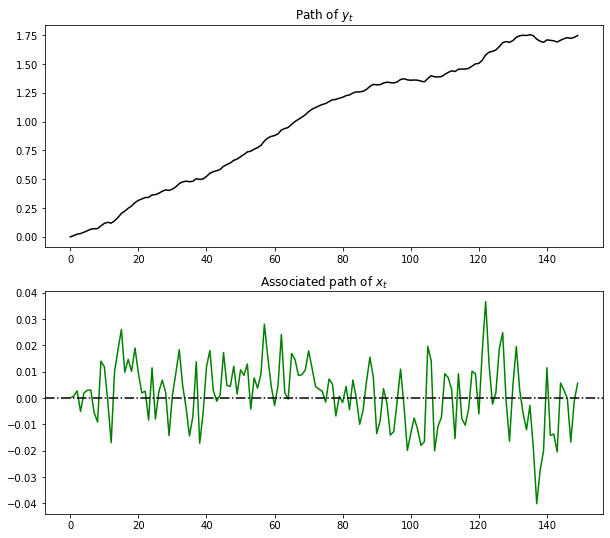

In [5]:
ϕ_1, ϕ_2, ϕ_3, ϕ_4 = 0.5, -0.2, 0, 0.5
σ = 0.01
ν = 0.01   # Growth rate

# A matrix should be n x n
A = np.array([[ϕ_1, ϕ_2, ϕ_3, ϕ_4],
              [  1,   0,   0,   0],
              [  0,   1,   0,   0],
              [  0,   0,   1,   0]])

# B matrix should be n x k
B = np.array([[σ, 0, 0, 0]]).T

D = np.array([1, 0, 0, 0]) @ A
F = np.array([1, 0, 0, 0]) @ B

amf = AMF_LSS_VAR(A, B, D, F, ν=ν)

T = 150
x, y = amf.lss.simulate(T)

fig, ax = plt.subplots(2, 1, figsize=(10, 9))

ax[0].plot(np.arange(T), y[amf.nx, :], color='k')
ax[0].set_title('Path of $y_t$')
ax[1].plot(np.arange(T), y[0, :], color='g')
ax[1].axhline(0, color='k', linestyle='-.')
ax[1].set_title('Associated path of $x_t$')
plt.show()

Notice the irregular but persistent growth in $y_t$.

### Decomposition

Hansen and Sargent {cite}`Hans_Sarg_book` describe how to construct a decomposition of
an additive functional into four parts:

- a constant inherited from initial values $x_0$ and $y_0$
- a linear trend
- a martingale
- an (asymptotically) stationary component

To attain this decomposition for the particular class of additive
functionals defined by {eq}`old1_additive_functionals` and {eq}`old2_additive_functionals`, we first construct the matrices

$$
\begin{aligned}
  H & := F + D (I - A)^{-1} B
  \\
  g & := D (I - A)^{-1}
\end{aligned}
$$

Then the Hansen {cite}`Hansen_2012_Eca`, {cite}`Hans_Sarg_book` decomposition is

$$
\begin{aligned}
  y_t
  &= \underbrace{t \nu}_{\text{trend component}} +
     \overbrace{\sum_{j=1}^t H z_j}^{\text{Martingale component}} -
     \underbrace{g x_t}_{\text{stationary component}} +
     \overbrace{g x_0 + y_0}^{\text{initial conditions}}
\end{aligned}
$$

At this stage, you should pause and verify that $y_{t+1} - y_t$ satisfies {eq}`old2_additive_functionals`.

It is convenient for us to introduce the following notation:

- $\tau_t = \nu t$ , a linear, deterministic trend
- $m_t = \sum_{j=1}^t H z_j$, a martingale with time $t+1$ increment $H z_{t+1}$
- $s_t = g x_t$, an (asymptotically) stationary component

We want to characterize and simulate components $\tau_t, m_t, s_t$ of the decomposition.

A convenient way to do this is to construct an appropriate instance of a [linear state space system](https://python-intro.quantecon.org/linear_models.html) by using [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) from [QuantEcon.py](http://quantecon.org/quantecon-py).

This will allow us to use the routines in [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) to study dynamics.

To start, observe that, under the dynamics in {eq}`old1_additive_functionals` and {eq}`old2_additive_functionals` and with the
definitions just given,

$$
\begin{bmatrix}
    1 \\
    t+1 \\
    x_{t+1} \\
    y_{t+1} \\
    m_{t+1}
\end{bmatrix} =
\begin{bmatrix}
    1 & 0 & 0 & 0 & 0 \\
    1 & 1 & 0 & 0 & 0 \\
    0 & 0 & A & 0 & 0 \\
    \nu & 0 & D & 1 & 0 \\
    0 & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
    1 \\
    t \\
    x_t \\
    y_t \\
    m_t
\end{bmatrix} +
\begin{bmatrix}
    0 \\
    0 \\
    B \\
    F \\
    H
\end{bmatrix}
z_{t+1}
$$

and

$$
\begin{bmatrix}
    x_t \\
    y_t \\
    \tau_t \\
    m_t \\
    s_t
\end{bmatrix} =
\begin{bmatrix}
    0 & 0 & I & 0 & 0 \\
    0 & 0 & 0 & 1 & 0 \\
    0 & \nu & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 1 \\
    0 & 0 & -g & 0 & 0
\end{bmatrix}
\begin{bmatrix}
    1 \\
    t \\
    x_t \\
    y_t \\
    m_t
\end{bmatrix}
$$

With

$$
\tilde{x} := \begin{bmatrix} 1 \\ t \\ x_t \\ y_t \\ m_t \end{bmatrix}
\quad \text{and} \quad
\tilde{y} := \begin{bmatrix} x_t \\ y_t \\ \tau_t \\ m_t \\ s_t \end{bmatrix}
$$

we can write this as the linear state space system

$$
\begin{aligned}
  \tilde{x}_{t+1} &= \tilde{A} \tilde{x}_t + \tilde{B} z_{t+1} \\
  \tilde{y}_{t} &= \tilde{D} \tilde{x}_t
\end{aligned}
$$

By picking out components of $\tilde y_t$, we can track all variables of
interest.

## Code

The class `AMF_LSS_VAR` mentioned {ref}`above <amf_lss>` does all that we want to study our additive functional.

In fact, `AMF_LSS_VAR` does more
because it allows us to study  an associated multiplicative functional as well.

(A hint that it does more is the name of the class -- here AMF stands for
"additive and multiplicative functional" -- the code computes and displays objects associated with
multiplicative functionals too.)

Let's use this code (embedded above) to explore the {ref}`example process described above <addfunc_eg1>`.

If you run {ref}`the code that first simulated that example <addfunc_egcode>` again and then the method call
you will generate (modulo randomness) the plot

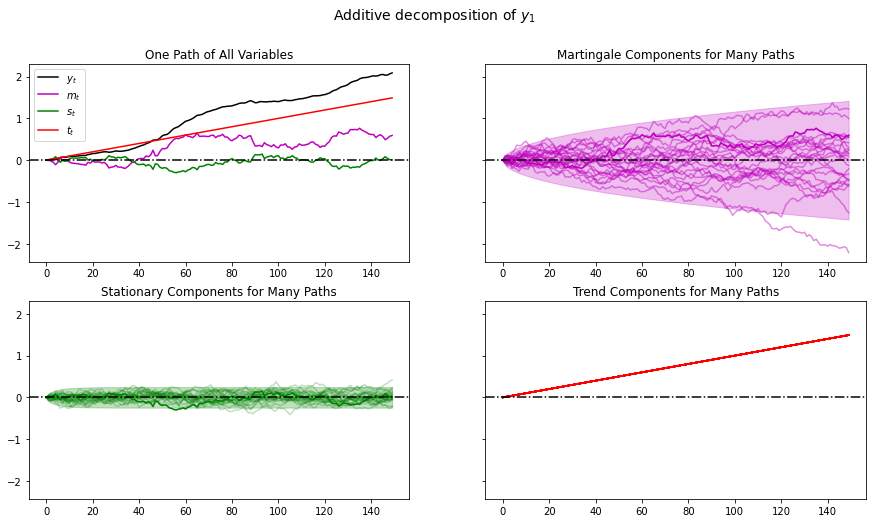

In [6]:
plot_additive(amf, T)
plt.show()

When we plot multiple realizations of a component in the 2nd, 3rd, and 4th panels, we also plot the population 95% probability coverage sets computed using the LinearStateSpace class.

We have chosen to simulate many paths, all starting from the *same* non-random initial conditions $x_0, y_0$ (you can tell this from the shape of the 95% probability coverage shaded areas).

Notice tell-tale signs of these probability coverage shaded areas

* the purple one for the martingale component $m_t$ grows with
  $\sqrt{t}$
* the green one for the stationary component $s_t$ converges to a
  constant band

### Associated Multiplicative Functional

Where $\{y_t\}$ is our additive functional, let $M_t = \exp(y_t)$.

As mentioned above, the process $\{M_t\}$ is called a **multiplicative functional**.

Corresponding to the additive decomposition described above we have a multiplicative decomposition of  $M_t$

$$
\frac{M_t}{M_0}
= \exp (t \nu) \exp \Bigl(\sum_{j=1}^t H \cdot Z_j \Bigr) \exp \biggl( D(I-A)^{-1} x_0 - D(I-A)^{-1} x_t \biggr)
$$

or

$$
\frac{M_t}{M_0} =  \exp\left( \tilde \nu t \right) \Biggl( \frac{\widetilde M_t}{\widetilde M_0}\Biggr) \left( \frac{\tilde e (X_0)} {\tilde e(x_t)} \right)
$$

where

$$
\tilde \nu =  \nu + \frac{H \cdot H}{2} ,
\quad
\widetilde M_t = \exp \biggl( \sum_{j=1}^t \biggl(H \cdot z_j -\frac{ H \cdot H }{2} \biggr) \biggr),  \quad \widetilde M_0 =1
$$

and

$$
\tilde e(x) = \exp[g(x)] = \exp \bigl[ D (I - A)^{-1} x \bigr]
$$

An instance of class `AMF_LSS_VAR` ({ref}`above <amf_lss>`)  includes this associated multiplicative functional as an attribute.

Let's plot this multiplicative functional for our example.

If you run {ref}`the code that first simulated that example <addfunc_egcode>` again and then the method call in the cell below you'll
obtain the graph in the next cell.

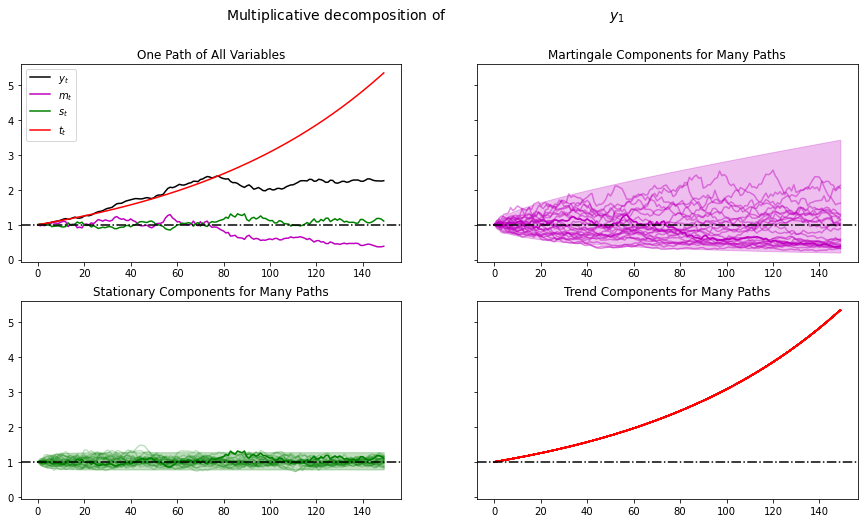

In [7]:
plot_multiplicative(amf, T)
plt.show()

As before, when we plotted multiple realizations of a component in the 2nd, 3rd, and 4th panels, we also plotted population 95% confidence bands computed using the LinearStateSpace class.

Comparing this figure and the last also helps show how geometric growth differs from
arithmetic growth.

The top right panel of the above graph shows a panel of martingales associated with the panel of $M_t = \exp(y_t)$ that we have generated
for a limited horizon $T$.

It is interesting to how the martingale behaves as $T \rightarrow +\infty$.

Let's see what happens when we set $T = 12000$ instead of $150$.

### Peculiar Large Sample Property

Hansen and Sargent {cite}`Hans_Sarg_book` (ch. 8) describe the following two properties of the  martingale component
$\widetilde M_t$ of the multiplicative decomposition

* while $E_0 \widetilde M_t = 1$ for all $t \geq 0$,
  nevertheless $\ldots$
* as $t \rightarrow +\infty$, $\widetilde M_t$ converges to
  zero almost surely

The first property follows from the fact that $\widetilde M_t$ is a multiplicative martingale with initial condition
$\widetilde M_0 = 1$.

The second is a **peculiar property** noted and proved by Hansen and Sargent {cite}`Hans_Sarg_book`.

The following simulation of many paths of $\widetilde M_t$ illustrates both properties

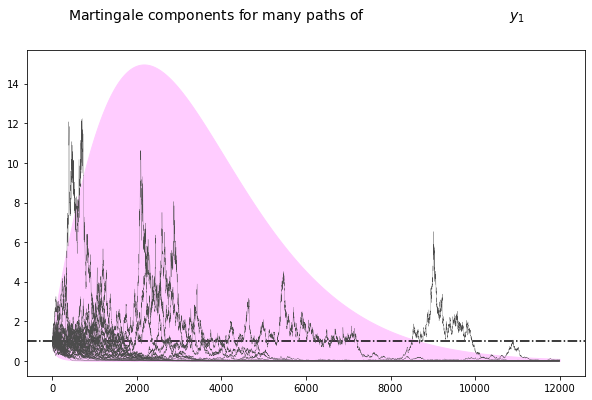

In [8]:
np.random.seed(10021987)
plot_martingales(amf, 12000)
plt.show()

The dotted line in the above graph is the mean $E \tilde M_t = 1$ of the martingale.

It remains constant at unity, illustrating the first property.

The purple 95 percent frequency coverage interval collapses around zero, illustrating the second property.

## More About the Multiplicative Martingale

Let's drill down and study probability distribution of the multiplicative martingale  $\{\widetilde M_t\}_{t=0}^\infty$  in
more detail.

As we  have seen, it has representation

$$
\widetilde M_t = \exp \biggl( \sum_{j=1}^t \biggl(H \cdot z_j -\frac{ H \cdot H }{2} \biggr) \biggr),  \quad \widetilde M_0 =1
$$

where $H =  [F + D(I-A)^{-1} B]$.

It follows that $\log {\widetilde M}_t \sim {\mathcal N} ( -\frac{t H \cdot H}{2}, t H \cdot H )$ and that consequently ${\widetilde M}_t$ is log normal.

### Simulating a Multiplicative Martingale Again

Next, we want a program to simulate the likelihood ratio process $\{ \tilde{M}_t \}_{t=0}^\infty$.

In particular, we want to simulate 5000 sample paths of length $T$ for the case in which $x$ is a scalar and
$[A, B, D, F] = [0.8, 0.001, 1.0, 0.01]$ and $\nu = 0.005$.

After accomplishing this, we want to display and study histograms of $\tilde{M}_T^i$ for various values of  $T$.

Here is code that accomplishes these tasks.

### Sample Paths

Let's write a program to simulate sample paths of $\{ x_t, y_{t} \}_{t=0}^{\infty}$.

We'll do this by formulating the additive functional as a linear state space model and putting the [LinearStateSpace](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lss.py) class to work.

In [9]:
class AMF_LSS_VAR:
    """
    This class is written to transform a scalar additive functional
    into a linear state space system.
    """
    def __init__(self, A, B, D, F=0.0, ν=0.0):
        # Unpack required elements
        self.A, self.B, self.D, self.F, self.ν = A, B, D, F, ν

        # Create space for additive decomposition
        self.add_decomp = None
        self.mult_decomp = None

        # Construct BIG state space representation
        self.lss = self.construct_ss()

    def construct_ss(self):
        """
        This creates the state space representation that can be passed
        into the quantecon LSS class.
        """
        # Pull out useful info
        A, B, D, F, ν = self.A, self.B, self.D, self.F, self.ν
        nx, nk, nm = 1, 1, 1
        if self.add_decomp:
            ν, H, g = self.add_decomp
        else:
            ν, H, g = self.additive_decomp()

        # Build A matrix for LSS
        # Order of states is: [1, t, xt, yt, mt]
        A1 = np.hstack([1, 0, 0, 0, 0])       # Transition for 1
        A2 = np.hstack([1, 1, 0, 0, 0])       # Transition for t
        A3 = np.hstack([0, 0, A, 0, 0])       # Transition for x_{t+1}
        A4 = np.hstack([ν, 0, D, 1, 0])       # Transition for y_{t+1}
        A5 = np.hstack([0, 0, 0, 0, 1])       # Transition for m_{t+1}
        Abar = np.vstack([A1, A2, A3, A4, A5])

        # Build B matrix for LSS
        Bbar = np.vstack([0, 0, B, F, H])

        # Build G matrix for LSS
        # Order of observation is: [xt, yt, mt, st, tt]
        G1 = np.hstack([0, 0, 1, 0, 0])            # Selector for x_{t}
        G2 = np.hstack([0, 0, 0, 1, 0])            # Selector for y_{t}
        G3 = np.hstack([0, 0, 0, 0, 1])            # Selector for martingale
        G4 = np.hstack([0, 0, -g, 0, 0])           # Selector for stationary
        G5 = np.hstack([0, ν, 0, 0, 0])            # Selector for trend
        Gbar = np.vstack([G1, G2, G3, G4, G5])

        # Build H matrix for LSS
        Hbar = np.zeros((1, 1))

        # Build LSS type
        x0 = np.hstack([1, 0, 0, 0, 0])
        S0 = np.zeros((5, 5))
        lss = qe.lss.LinearStateSpace(Abar, Bbar, Gbar, Hbar,
                                      mu_0=x0, Sigma_0=S0)

        return lss

    def additive_decomp(self):
        """
        Return values for the martingale decomposition (Proposition 4.3.3.)
           - ν     : unconditional mean difference in Y
           - H     : coefficient for the (linear) martingale component (kappa_a)
           - g     : coefficient for the stationary component g(x)
           - Y_0   : it should be the function of X_0 (for now set it to 0.0)
        """
        A_res = 1 / (1 - self.A)
        g = self.D * A_res
        H = self.F + self.D * A_res * self.B

        return self.ν, H, g

    def multiplicative_decomp(self):
        """
        Return values for the multiplicative decomposition (Example 5.4.4.)
            - ν_tilde  : eigenvalue
            - H        : vector for the Jensen term
        """
        ν, H, g = self.additive_decomp()
        ν_tilde = ν + (.5) * H**2

        return ν_tilde, H, g

    def loglikelihood_path(self, x, y):
        A, B, D, F = self.A, self.B, self.D, self.F
        T = y.T.size
        FF = F**2
        FFinv = 1 / FF
        temp = y[1:] - y[:-1] - D * x[:-1]
        obs = temp * FFinv * temp
        obssum = np.cumsum(obs)
        scalar = (np.log(FF) + np.log(2 * np.pi)) * np.arange(1, T)

        return (-0.5) * (obssum + scalar)

    def loglikelihood(self, x, y):
        llh = self.loglikelihood_path(x, y)

        return llh[-1]

The heavy lifting is done inside the `AMF_LSS_VAR` class.

The following code adds some simple functions that make it straightforward to generate sample paths from an instance of `AMF_LSS_VAR`.

In [10]:
def simulate_xy(amf, T):
    "Simulate individual paths."
    foo, bar = amf.lss.simulate(T)
    x = bar[0, :]
    y = bar[1, :]

    return x, y

def simulate_paths(amf, T=150, I=5000):
    "Simulate multiple independent paths."

    # Allocate space
    storeX = np.empty((I, T))
    storeY = np.empty((I, T))

    for i in range(I):
        # Do specific simulation
        x, y = simulate_xy(amf, T)

        # Fill in our storage matrices
        storeX[i, :] = x
        storeY[i, :] = y

    return storeX, storeY

def population_means(amf, T=150):
    # Allocate Space
    xmean = np.empty(T)
    ymean = np.empty(T)

    # Pull out moment generator
    moment_generator = amf.lss.moment_sequence()

    for tt in range (T):
        tmoms = next(moment_generator)
        ymeans = tmoms[1]
        xmean[tt] = ymeans[0]
        ymean[tt] = ymeans[1]

    return xmean, ymean

Now that we have these functions in our toolkit, let's apply them to run some
simulations.

In [11]:
def simulate_martingale_components(amf, T=1000, I=5000):
    # Get the multiplicative decomposition
    ν, H, g = amf.multiplicative_decomp()

    # Allocate space
    add_mart_comp = np.empty((I, T))

    # Simulate and pull out additive martingale component
    for i in range(I):
        foo, bar = amf.lss.simulate(T)

        # Martingale component is third component
        add_mart_comp[i, :] = bar[2, :]

    mul_mart_comp = np.exp(add_mart_comp - (np.arange(T) * H**2)/2)

    return add_mart_comp, mul_mart_comp


# Build model
amf_2 = AMF_LSS_VAR(0.8, 0.001, 1.0, 0.01,.005)

amc, mmc = simulate_martingale_components(amf_2, 1000, 5000)

amcT = amc[:, -1]
mmcT = mmc[:, -1]

print("The (min, mean, max) of additive Martingale component in period T is")
print(f"\t ({np.min(amcT)}, {np.mean(amcT)}, {np.max(amcT)})")

print("The (min, mean, max) of multiplicative Martingale component \
in period T is")
print(f"\t ({np.min(mmcT)}, {np.mean(mmcT)}, {np.max(mmcT)})")

The (min, mean, max) of additive Martingale component in period T is
	 (-1.8379907335579106, 0.011040789361757435, 1.4697384727035145)
The (min, mean, max) of multiplicative Martingale component in period T is
	 (0.14222026893384476, 1.006753060146832, 3.8858858377907133)


Let's plot the probability density functions for $\log {\widetilde M}_t$ for
$t=100, 500, 1000, 10000, 100000$.

Then let's use the plots to  investigate how these densities evolve through time.

We will plot the densities of $\log {\widetilde M}_t$ for different values of $t$.

Note: `scipy.stats.lognorm` expects you to pass the standard deviation
first $(tH \cdot H)$ and then the exponent of the mean as a
keyword argument `scale` (`scale=np.exp(-t * H2 / 2)`).

* See the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html#scipy.stats.lognorm).

This is peculiar, so make sure you are careful in working with the log normal distribution.

Here is some code that tackles these tasks

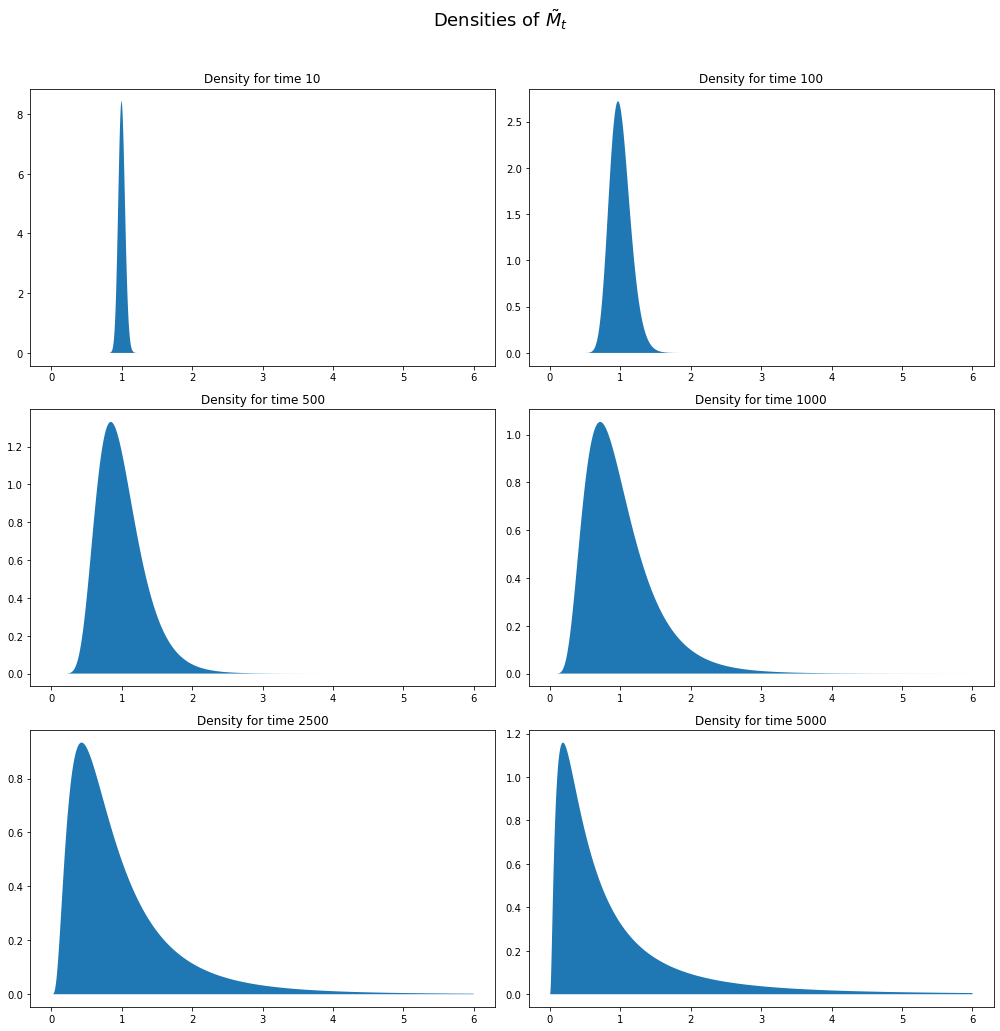

In [12]:
def Mtilde_t_density(amf, t, xmin=1e-8, xmax=5.0, npts=5000):

    # Pull out the multiplicative decomposition
    νtilde, H, g = amf.multiplicative_decomp()
    H2 = H*H

    # The distribution
    mdist = lognorm(np.sqrt(t*H2), scale=np.exp(-t*H2/2))
    x = np.linspace(xmin, xmax, npts)
    pdf = mdist.pdf(x)

    return x, pdf


def logMtilde_t_density(amf, t, xmin=-15.0, xmax=15.0, npts=5000):

    # Pull out the multiplicative decomposition
    νtilde, H, g = amf.multiplicative_decomp()
    H2 = H*H

    # The distribution
    lmdist = norm(-t*H2/2, np.sqrt(t*H2))
    x = np.linspace(xmin, xmax, npts)
    pdf = lmdist.pdf(x)

    return x, pdf


times_to_plot = [10, 100, 500, 1000, 2500, 5000]
dens_to_plot = map(lambda t: Mtilde_t_density(amf_2, t, xmin=1e-8, xmax=6.0),
                   times_to_plot)
ldens_to_plot = map(lambda t: logMtilde_t_density(amf_2, t, xmin=-10.0,
                    xmax=10.0), times_to_plot)

fig, ax = plt.subplots(3, 2, figsize=(14, 14))
ax = ax.flatten()

fig.suptitle(r"Densities of $\tilde{M}_t$", fontsize=18, y=1.02)
for (it, dens_t) in enumerate(dens_to_plot):
    x, pdf = dens_t
    ax[it].set_title(f"Density for time {times_to_plot[it]}")
    ax[it].fill_between(x, np.zeros_like(pdf), pdf)

plt.tight_layout()
plt.show()

These probability density functions help us understand mechanics underlying the  **peculiar property** of our multiplicative martingale

* As $T$ grows, most of the probability mass shifts leftward toward zero.
* For example, note that most  mass is near $1$ for $T =10$ or $T = 100$ but
  most of it is near $0$ for $T = 5000$.
* As $T$ grows, the tail of the density of $\widetilde M_T$ lengthens toward the right.
* Enough mass moves toward the right tail to keep $E \widetilde M_T = 1$
  even as most mass in the distribution of $\widetilde M_T$ collapses around $0$.

### Multiplicative Martingale as Likelihood Ratio Process

[This lecture](https://python.quantecon.org/likelihood_ratio_process.html) studies **likelihood processes**
and **likelihood ratio processes**.

A **likelihood ratio process** is  a  multiplicative  martingale with mean unity.

Likelihood ratio processes exhibit the peculiar property that naturally also appears
[here](https://python.quantecon.org/likelihood_ratio_process.html).